
回帰の設定

腫瘤の特徴量が量的変数、診断結果が2値の質的変数である 

→腫瘤の特徴量の平均から診断結果が悪性である確率を予測する二項ロジスティック回帰モデルを作成する

https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

In [ ]:
import pymc3 as pm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

cancer = pd.read_csv('/input/breast-cancer-wisconsin-data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
y_0 = pd.Categorical(cancer['diagnosis']).codes # 目的変数として診断結果
x_n = [2,3,4,5,6,7,8,9,10,11]
x_0 = cancer.iloc[:, [2,3,4,5,6,7,8,9,10,11]].values # 説明変数として腫瘤の特徴量
x_0 = (x_0 - x_0.mean(axis=0)/x_0.std(axis=0))

説明変数が腫瘤の特徴量の平均，目的変数が診断結果である

$\mu=\alpha+\beta X$ \\
$\theta=\operatorname{logistic}(\mu)$ \\
$y \sim \operatorname{Bern}(\theta)$

の二項ロジスティック回帰モデルを作る


In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))

    mu = alpha +pm.math.dot(x_0, beta)
    theta = 1/(1+pm.math.exp(-mu))

    likelihood = pm.Bernoulli('y', p=theta, observed=y_0)

In [ ]:
with model:
    trace = pm.sample(5000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 1043 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22234afd10>,
      dtype=object)

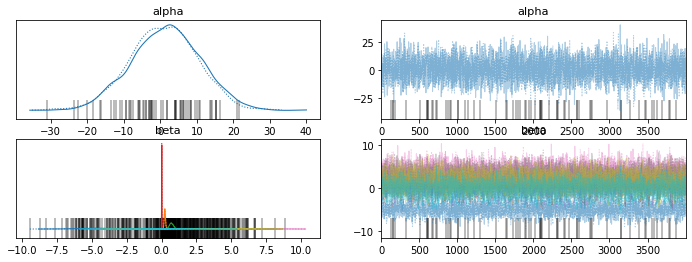

In [ ]:
pm.traceplot(trace_n)

In [ ]:
print(trace['alpha'].mean(axis = 0))

1.2527306861253524


In [ ]:
print(trace['beta'].mean(axis = 0))

[-4.8411213   0.23461822  0.70846349  0.01320913  1.20070411  1.73814532
  3.6568612   2.22361005  1.68062068 -0.17689839]


サンプリングで得られたパラメータの平均を用いた回帰モデルに対して腫瘤の特徴量を入力値とした予測値を生成

In [ ]:
data_pred =trace['alpha'].mean(axis=0)+np.dot(x_0,trace["beta"].mean(axis=0))
y_pred=[]
y_pred_binary=[]
for point in data_pred:
  y_pred.append(1/(1+np.exp(-point)))
y_pred=np.array(y_pred)
y_pred_binary = np.where(y_pred>0.5, 1, 0)
np.sum(y_0==y_pred_binary,axis=0)/len(y_0)

0.9156414762741653